# Graphs from summary Excel

This notebook reads the analysis summary Excel and generates three plots:

1. Distribution of timeseries lengths (only series with completeness >90%) with normal fit.
2. Largest time gap per series (hours) histogram (0..24) and counts >24h, >48h.
3. Bar chart of series grouped by number of jumps >0.3m into buckets: 0-4, 5-9, 10-19, 20-49, 50+.

Plots are saved in `output_data/figures` and shown inline.

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

# --- repo discovery and data load ---
repo_root = Path.cwd()
for candidate in [repo_root] + list(repo_root.parents):
    if (candidate / '.git').exists() or (candidate / 'pyproject.toml').exists():
        repo_root = candidate
        break
print('Repo root:', repo_root)

summary_xlsx = repo_root / 'output_data' / 'analysis_fugro_wiertsema.xlsx'
fallback_xlsx = repo_root / 'output_data' / 'analysis_per_series_stats.xlsx'

if summary_xlsx.exists():
    df = pd.read_excel(summary_xlsx)
    print('Loaded', summary_xlsx)
elif fallback_xlsx.exists():
    df = pd.read_excel(fallback_xlsx)
    print('Loaded', fallback_xlsx)
else:
    raise FileNotFoundError('Summary Excel not found in output_data')

# ---------- tolerant column detection ----------
def _norm(s: str) -> str:
    # lower + remove all non-alphanumerics for fuzzy matching
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

def find_col(df, candidates):
    norm_map = {_norm(c): c for c in df.columns}
    for cand in candidates:
        key = _norm(cand)
        if key in norm_map:
            return norm_map[key]
    return None

# Try multiple aliases for each logical field
comp_col    = find_col(df, [
    'timestamps_with_data_pct','completeness_pct','timestamps_with_data_percentage','completeness'
])
expected_col= find_col(df, [
    'expected_timestamps','expected_count','expected'
])
actual_col  = find_col(df, [
    'actual_count','counted_timestamps','length','n'
])
jumps_col   = find_col(df, [
    'jumps_gt_0.3','jumps_gt_0_3','jumps'
])
gap_col     = find_col(df, [
    'max_gap_hours','largest_gap_hours','longest_gap_hours','max_gap'
])

print('Columns resolved:')
print('  completeness  ->', comp_col)
print('  expected      ->', expected_col)
print('  actual        ->', actual_col)
print('  jumps         ->', jumps_col)
print('  gap(hours)    ->', gap_col)

# ---------- build a normalized working frame for plots ----------
work = df.copy()

# completeness (%)
if comp_col:
    work['completeness'] = pd.to_numeric(work[comp_col], errors='coerce')
else:
    # derive if possible from actual / expected
    if expected_col and actual_col:
        exp_ = pd.to_numeric(work[expected_col], errors='coerce')
        act_ = pd.to_numeric(work[actual_col], errors='coerce')
        work['completeness'] = np.where(exp_>0, (act_/exp_)*100.0, np.nan)
    else:
        work['completeness'] = np.nan
# clamp to [0,100]
work['completeness'] = work['completeness'].clip(lower=0, upper=100)

# estimated_length (number of timestamps)
if expected_col and comp_col:
    exp_ = pd.to_numeric(work[expected_col], errors='coerce')
    cmp_ = pd.to_numeric(work['completeness'], errors='coerce')
    work['estimated_length'] = (exp_ * (cmp_/100.0)).round()
elif expected_col:
    work['estimated_length'] = pd.to_numeric(work[expected_col], errors='coerce')
elif actual_col:
    work['estimated_length'] = pd.to_numeric(work[actual_col], errors='coerce')
else:
    work['estimated_length'] = np.nan

# jumps (integer)
if jumps_col:
    work['jumps'] = pd.to_numeric(work[jumps_col], errors='coerce').fillna(0).astype(int)
else:
    work['jumps'] = 0

# max gap in hours (float) — normalize to the name the plots expect
if gap_col:
    work['max_gap_hours'] = pd.to_numeric(work[gap_col], errors='coerce')
else:
    work['max_gap_hours'] = np.nan

# output dir for figures
out_fig = repo_root / 'output_data' / 'figures'
out_fig.mkdir(parents=True, exist_ok=True)

print(f'Prepared dataset with {len(work)} series')

Repo root: d:\Users\jvanruitenbeek\data_validation
Loaded d:\Users\jvanruitenbeek\data_validation\output_data\analysis_fugro_wiertsema.xlsx
Columns resolved:
  completeness  -> timestamps_with_data_pct
  expected      -> expected_timestamps
  actual        -> counted_timestamps
  jumps         -> jumps_gt_0.3
  gap(hours)    -> longest_gap_hours
Prepared dataset with 393 series


C:\Users\jvanruitenbeek\AppData\Local\Temp\35\ipykernel_26448\3627806189.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset.groupby(["days_bucket", "source"])


Saved d:\Users\jvanruitenbeek\data_validation\output_data\figures\lengths_completeness_gt90_by_source.png


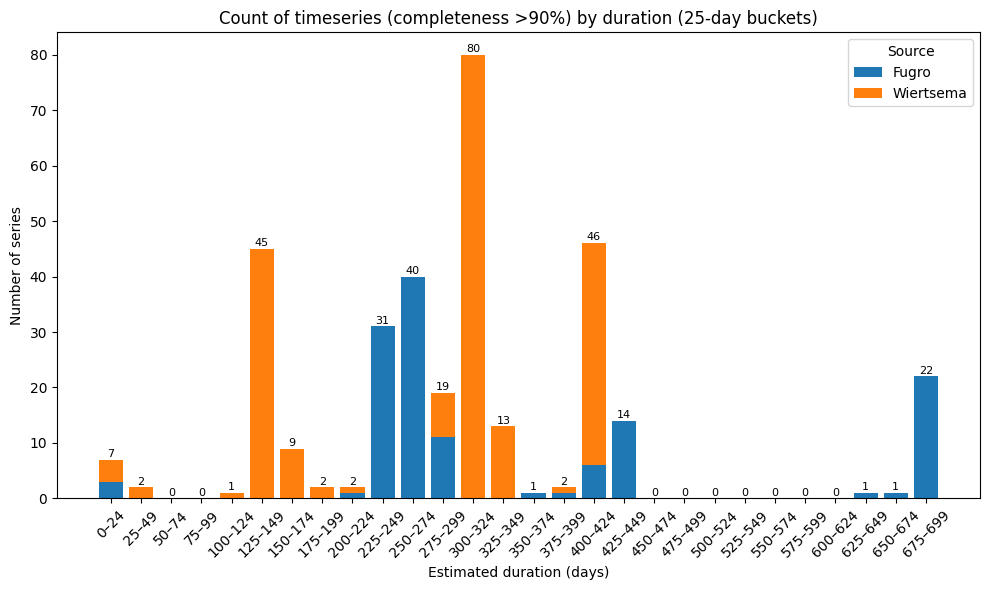

In [14]:
# Plot 1: lengths distribution (completeness >90%) in 25-day buckets, colored by 'source'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Guards and subset ---
required = {"completeness", "estimated_length", "source"}
missing = [c for c in required if c not in work.columns]
if missing:
    raise KeyError(f"Missing columns in 'work': {missing}")

subset = work[(work["completeness"] > 90) & work["estimated_length"].notna()].copy()

plt.figure(figsize=(10, 6))

if subset.empty:
    print("No series with completeness > 90% and a valid estimated_length.")
else:
    # Convert timestamps to days (24 hourly samples = 1 day)
    subset["estimated_days"] = subset["estimated_length"].astype(float) / 24.0

    # Define 25-day buckets
    bin_width = 25
    max_days = float(subset["estimated_days"].max())
    upper = int(np.ceil(max_days / bin_width) * bin_width) or bin_width
    bins = np.arange(0, upper + bin_width, bin_width)
    labels = [f"{int(b)}–{int(b + bin_width - 1)}" for b in bins[:-1]]

    # Assign bucket labels
    subset["days_bucket"] = pd.cut(
        subset["estimated_days"],
        bins=bins,
        labels=labels,
        right=False,
        include_lowest=True,
    )

    # --- Group by both source and bucket ---
    grouped = (
        subset.groupby(["days_bucket", "source"])
        .size()
        .unstack(fill_value=0)
        .reindex(labels, fill_value=0)
    )

    # Define colors per source
    color_map = {"fugro": "tab:blue", "wiertsema": "tab:orange"}
    sources = [s for s in grouped.columns if s in color_map]

    # --- Plot stacked bars ---
    bottom = np.zeros(len(grouped))
    for src in sources:
        plt.bar(
            grouped.index,
            grouped[src],
            bottom=bottom,
            color=color_map[src],
            label=src.capitalize(),
            width=0.8,
        )
        bottom += grouped[src].values

    # Annotate total count above each bar
    for i, total in enumerate(bottom):
        plt.text(i, total + 0.5, str(int(total)), ha="center", fontsize=8)

    plt.xticks(rotation=45)
    plt.title("Count of timeseries (completeness >90%) by duration (25-day buckets)")
    plt.xlabel("Estimated duration (days)")
    plt.ylabel("Number of series")
    plt.legend(title="Source")

    plt.tight_layout()
    out_path = out_fig / "lengths_completeness_gt90_by_source.png"
    plt.savefig(out_path, dpi=150)
    print(f"Saved {out_path}")

plt.show()


Saved d:\Users\jvanruitenbeek\data_validation\output_data\figures\largest_gap_hist_26bins_by_source.png


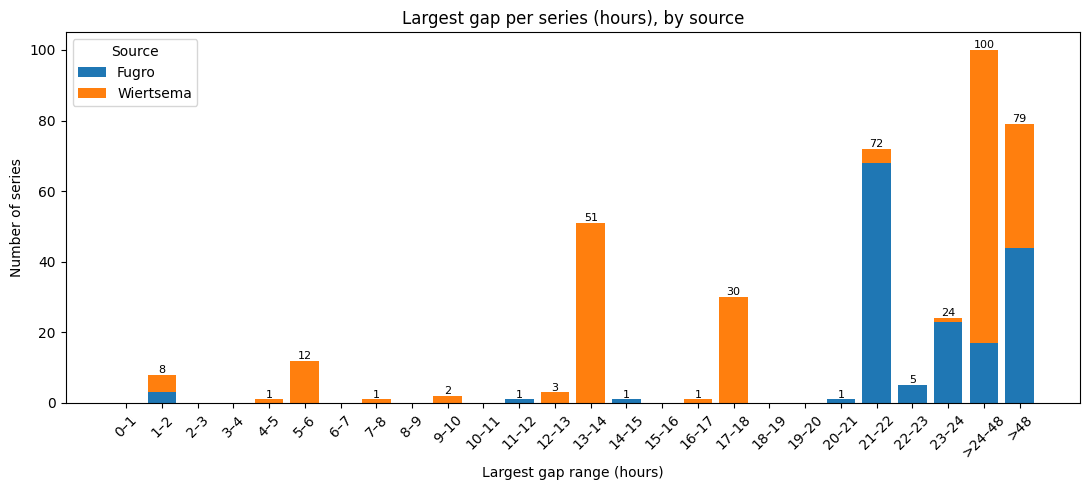

In [16]:
# Plot 2: largest gap histogram (hours) with 24 hourly bins + 2 overflow bins,
# stacked by source (Fugro vs Wiertsema)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 5))

# Guards
for col in ["max_gap_hours", "source"]:
    if col not in work.columns:
        raise KeyError(f"'{col}' column not found in work DataFrame")

# Prepare values
vals_all = pd.to_numeric(work["max_gap_hours"], errors="coerce")
src_all = work["source"].astype(str).str.lower()
mask_valid = vals_all.notna()
vals_all = vals_all[mask_valid]
src_all = src_all[mask_valid]

if vals_all.empty:
    print("No gap data available in the summary (max_gap_hours missing or empty).")
else:
    # Bin setup: 24 hourly bins (0..24) + two overflow bins
    base_bins = np.arange(0, 25, 1)  # edges 0..24 for 24 bins
    labels = [f"{int(b)}–{int(b+1)}" for b in base_bins[:-1]] + [">24–48", ">48"]

    sources = ["fugro", "wiertsema"]
    colors = {"fugro": "tab:blue", "wiertsema": "tab:orange"}

    # Count per source per bin
    counts_by_src = []
    for src in sources:
        v = vals_all[src_all == src]

        # 24 hourly bins
        hourly = v[v <= 24.0]
        cnt24, _ = np.histogram(hourly, bins=base_bins)

        # two overflow bins
        cnt_24_48 = ((v > 24.0) & (v <= 48.0)).sum()
        cnt_gt_48 = (v > 48.0).sum()

        counts_by_src.append(np.concatenate([cnt24, [cnt_24_48, cnt_gt_48]]))

    # Make stacked bars
    x = np.arange(len(labels))
    bottom = np.zeros_like(x, dtype=float)

    for src, counts in zip(sources, counts_by_src):
        plt.bar(x, counts, bottom=bottom, color=colors[src], width=0.8, label=src.capitalize())
        bottom += counts

    # Annotate totals above stacks
    for i, total in enumerate(bottom):
        if total > 0:
            plt.text(i, total + 0.5, str(int(total)), ha="center", fontsize=8)

    # X axis labels
    plt.xticks(x, labels, rotation=45)
    plt.title("Largest gap per series (hours), by source")
    plt.xlabel("Largest gap range (hours)")
    plt.ylabel("Number of series")
    plt.legend(title="Source")

    plt.tight_layout()
    out_path = out_fig / "largest_gap_hist_26bins_by_source.png"
    plt.savefig(out_path, dpi=150)
    print(f"Saved {out_path}")

plt.show()

Saved d:\Users\jvanruitenbeek\data_validation\output_data\figures\jumps_buckets_detailed_by_source.png


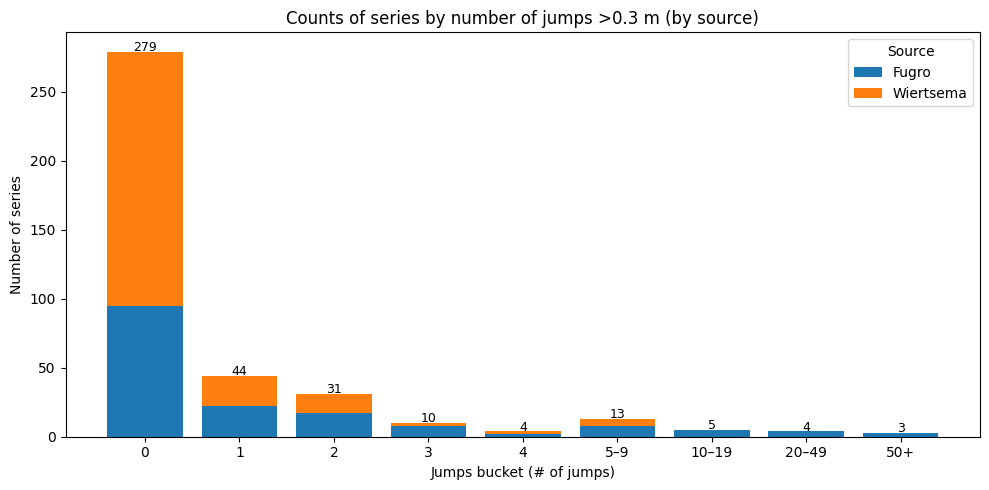

In [17]:
# Plot 3: detailed jumps buckets by source (0,1,2,3,4,5–9,10–19,20–49,50+), stacked Fugro/Wiertsema
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# --- Guards ---
for col in ["jumps", "source"]:
    if col not in work.columns:
        raise KeyError(f"'{col}' column not found in 'work'")

# --- Coerce and clean ---
jumps = pd.to_numeric(work["jumps"], errors="coerce").fillna(0).astype(int).clip(lower=0)
sources = work["source"].astype(str).str.lower()

# --- Define fine-grained buckets ---
bins   = [-0.1, 0.5, 1.5, 2.5, 3.5, 4.5, 10, 20, 50, np.inf]
labels = ["0", "1", "2", "3", "4", "5–9", "10–19", "20–49", "50+"]

bucket = pd.cut(jumps, bins=bins, labels=labels, right=False, include_lowest=True)

# Crosstab buckets x source, ensure consistent order
tab = pd.crosstab(bucket, sources).reindex(labels, fill_value=0)
src_order = ["fugro", "wiertsema"]  # enforce order
for s in src_order:
    if s not in tab.columns:
        tab[s] = 0
tab = tab[src_order]

# --- Plot stacked bars ---
x = np.arange(len(labels))
bottom = np.zeros(len(labels), dtype=float)
color_map = {"fugro": "tab:blue", "wiertsema": "tab:orange"}

for s in src_order:
    vals = tab[s].values
    plt.bar(x, vals, bottom=bottom, color=color_map[s], width=0.8, label=s.capitalize())
    bottom += vals

# Annotate totals above stacks
for i, total in enumerate(bottom):
    if total > 0:
        plt.text(i, total + 0.5, str(int(total)), ha="center", fontsize=9)

# Axes & save
plt.xticks(x, labels)
plt.title("Counts of series by number of jumps >0.3 m (by source)")
plt.xlabel("Jumps bucket (# of jumps)")
plt.ylabel("Number of series")
plt.legend(title="Source")
plt.tight_layout()

p3 = out_fig / "jumps_buckets_detailed_by_source.png"
plt.savefig(p3, dpi=150)
print("Saved", p3)

plt.show()